# Time series analysis from Kaggle Notebook
https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python

In [2]:
import warnings                                  # `do not disturb` mode
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta # working with dates with style
import hvplot as hv
import hvplot.pandas
from itertools import product                    # some useful functions
import matplotlib.pyplot as plt                  # plots
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
from pathlib import Path
from pypalettes import load_cmap, add_cmap
import seaborn as sns                            # more plots
from scipy.optimize import minimize              # for function minimization
import scipy.stats as scs
from sklearn.metrics import mean_absolute_percentage_error as mape
import statsmodels.api as sm
import statsmodels.formula.api                     # statistics and econometrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tqdm



# Festlegen der Farben
cmap = load_cmap("Apricot")
cmap_continuous = add_cmap(
    colors=["#FFFFFFFF", "#FFF9A1FF", "#BAD09DFF", "#76D3CFFF", "#459E9EFF", "#306677FF", "#24385FFF", "#132157FF"],
    name="apricot_continuous",
    cmap_type="continuous"
)
cmap8 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#005F73FF', '#9093A2FF', '#132157FF'],
    name="apricot8colors",
    cmap_type="discrete"
)
cmap7 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#9093A2FF', '#132157FF'],
    name="apricot7colors",
    cmap_type="discrete"
)


%matplotlib inline



In [3]:
# Load Timestamp of Dataset
df_daily = pd.read_csv('df_daily.csv')
df_hourly = pd.read_csv('df_hourly_2020.csv')
df_daily_test = pd.read_csv('df_daily_2024.csv')
df_hourly_test = pd.read_csv('df_hourly_2024.csv')


## Time series analysis in Python
Analyse aus: https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook 25.07.24, 10:56
Und aus Atwan.2022: *Time Series Analysis*. 10 Building Univariate Time Series Models Using Statistical Methods: https://learning.oreilly.com/library/view/time-series-analysis/9781805124283/text/ch011.xhtml#join-our-book-community-on-discord-9

### Hilfsfunkktionen

In [78]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

def get_top_models_df(scores, criterion='AIC', top_n=5):
    sorted_scores = sorted(scores.items(),
                           key=lambda item: item[1][criterion])
   
    top_models = sorted_scores[:top_n]
    data = [v for k, v in top_models]
    df = pd.DataFrame(data)
   
    df['model_id'] = [k for k, v in top_models]
    df.set_index('model_id', inplace=True)
    return df

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

def mean_absolute_error(actual, predicted):
    """
    Berechnet den mittleren absoluten Fehler (MAE) zwischen zwei Zeitreihen.
    
    Parameters:
        actual (pd.Series or np.ndarray): Die tatsächlichen Werte.
        predicted (pd.Series or np.ndarray): Die vorhergesagten Werte (z. B. gleitender Mittelwert).
        
    Returns:
        float: Der mittlere absolute Fehler.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.mean(np.abs(actual - predicted))

def mean_squared_error(actual, predicted):
    """
    Berechnet den mittleren quadratischen Fehler (MSE) zwischen zwei Zeitreihen.
    
    Parameters:
        actual (pd.Series or np.ndarray): Die tatsächlichen Werte.
        predicted (pd.Series or np.ndarray): Die vorhergesagten Werte.
        
    Returns:
        float: Der mittlere quadratische Fehler.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.mean((actual - predicted) ** 2)

def mean_squared_log_error(actual, predicted):
    """
    Berechnet den mittleren logarithmischen quadratischen Fehler (MSLE).
    
    Parameters:
        actual (pd.Series or np.ndarray): Die tatsächlichen Werte.
        predicted (pd.Series or np.ndarray): Die vorhergesagten Werte.
        
    Returns:
        float: Der MSLE.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.mean((np.log1p(actual) - np.log1p(predicted)) ** 2)

def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Calculate the mean absolute percentage error (MAPE)
    
    Parameters:
        y_true (array-like): Actual values
        y_pred (array-like): Predicted values
    
    Returns:
        float: MAPE value in percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100

def combinator(items):
    combo = [i for i in product(*items)]
    return combo

In [62]:
# Berechnung des Gleitenden Mittelwertes
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(df_daily['calls'], 7) # Berechnung des Mittelswertes der letzten sieben Tage

np.float64(354.0)

In [64]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    
    # Plot actual values first to keep them in the background
    plt.plot(series, label="Actual values", color=cmap.colors[3])

    # Plot rolling mean trend
    plt.plot(rolling_mean, "g", label="Rolling mean trend", color=cmap.colors[1])

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()


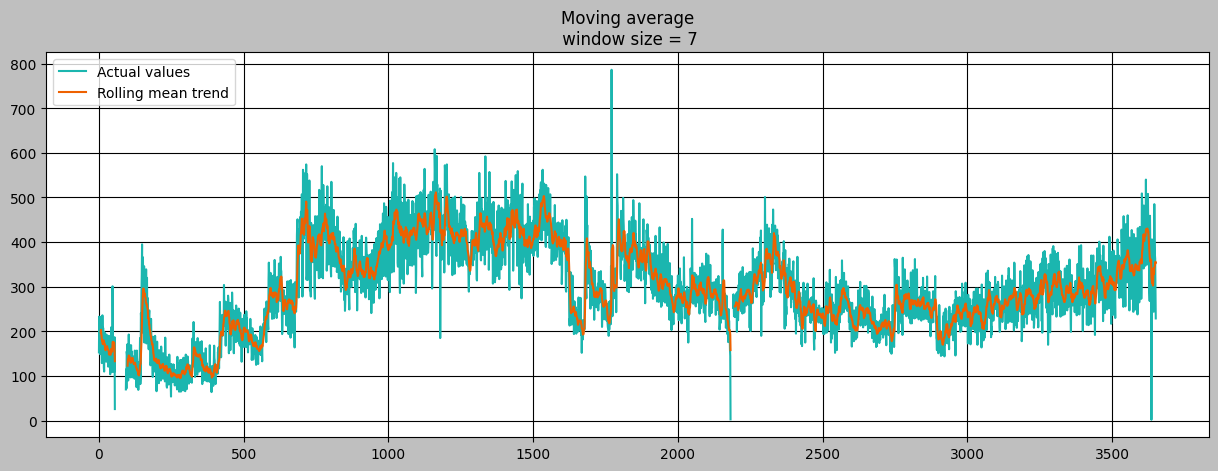

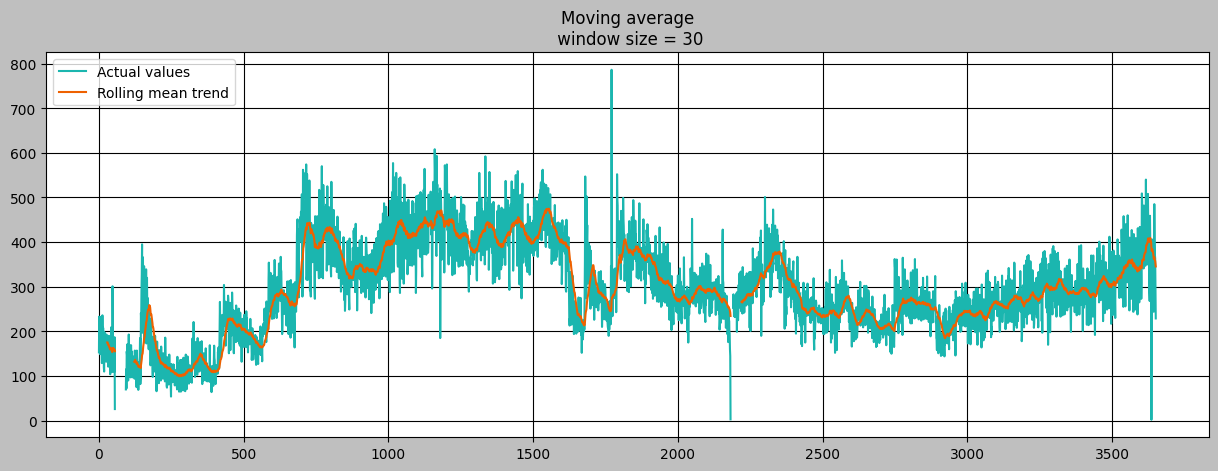

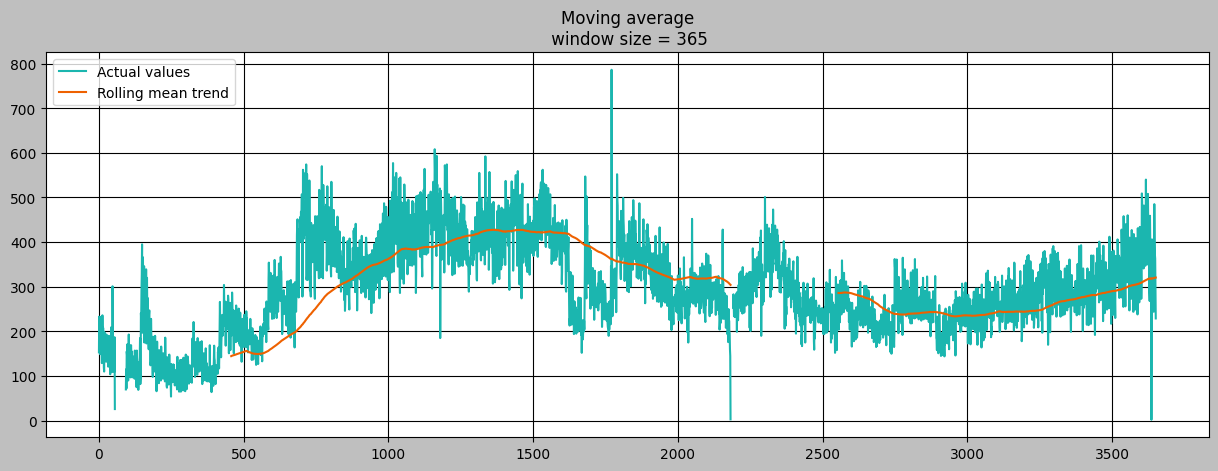

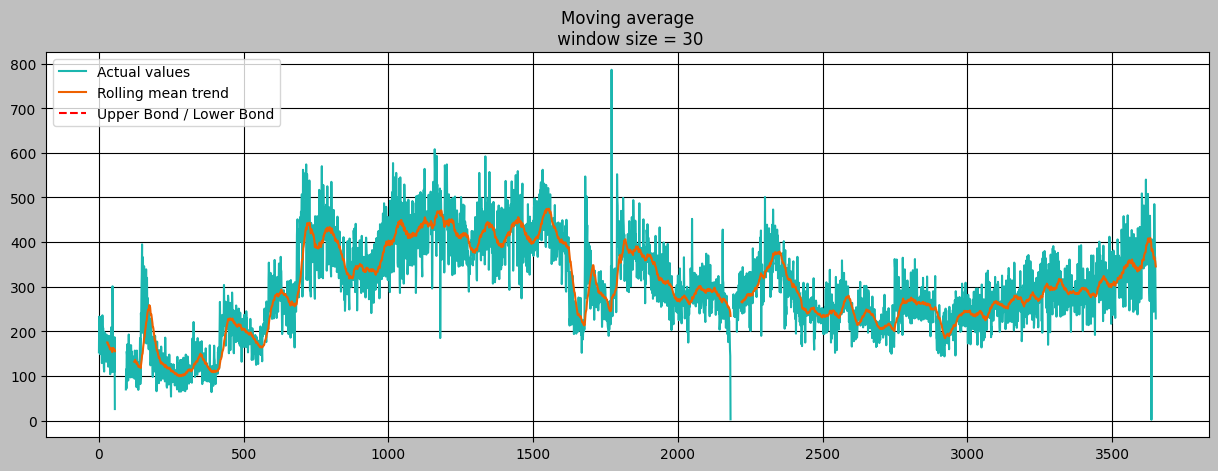

In [65]:
plotMovingAverage (df_daily['calls'], 7)



plotMovingAverage (df_daily['calls'], 30)



plotMovingAverage (df_daily['calls'], 365) 



plotMovingAverage(df_daily['calls'], 30, plot_intervals=True, plot_anomalies= True)


### Gewichteter Durchschnitt

In [10]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [11]:
weighted_average(df_daily['calls'], [0.6, 0.3, 0.1])

263.40000000000003

### Exponentielle Glättung

In [12]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

## Error Metrics

In [ ]:
mean_squared_error(y_true=df_hourly_test['calls'],
                   y_pred=df_hourly_test_fcst['yhat'])

3244.6152271171745

In [ ]:
mean_absolute_error(y_true=df_hourly_test['calls'],
                   y_pred=df_hourly_test_fcst['yhat'])

45.8731909006002

In [ ]:
df_hourly_test['calls']

date
2023-07-01 01:00:00     8
2023-07-01 02:00:00     0
2023-07-01 03:00:00     3
2023-07-01 04:00:00    16
2023-07-01 05:00:00     4
                       ..
2023-12-31 19:00:00    98
2023-12-31 20:00:00    84
2023-12-31 21:00:00    68
2023-12-31 22:00:00    34
2023-12-31 23:00:00    47
Name: calls, Length: 4415, dtype: int64

In [ ]:
df_hourly_test_fcst['yhat']

0        93.675124
1        60.260638
2        31.835489
3        23.470189
4        33.353763
           ...    
4410     62.843316
4411     52.785892
4412     58.545595
4413     82.196797
4414    109.137841
Name: yhat, Length: 4415, dtype: float64

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Filtere die Nullwerte aus
    non_zero_indices = y_true != 0
    y_true = y_true[non_zero_indices]
    y_pred = y_pred[non_zero_indices]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df_hourly_test['calls'],
                   y_pred=df_hourly_test_fcst['yhat'])


220.64453893446503

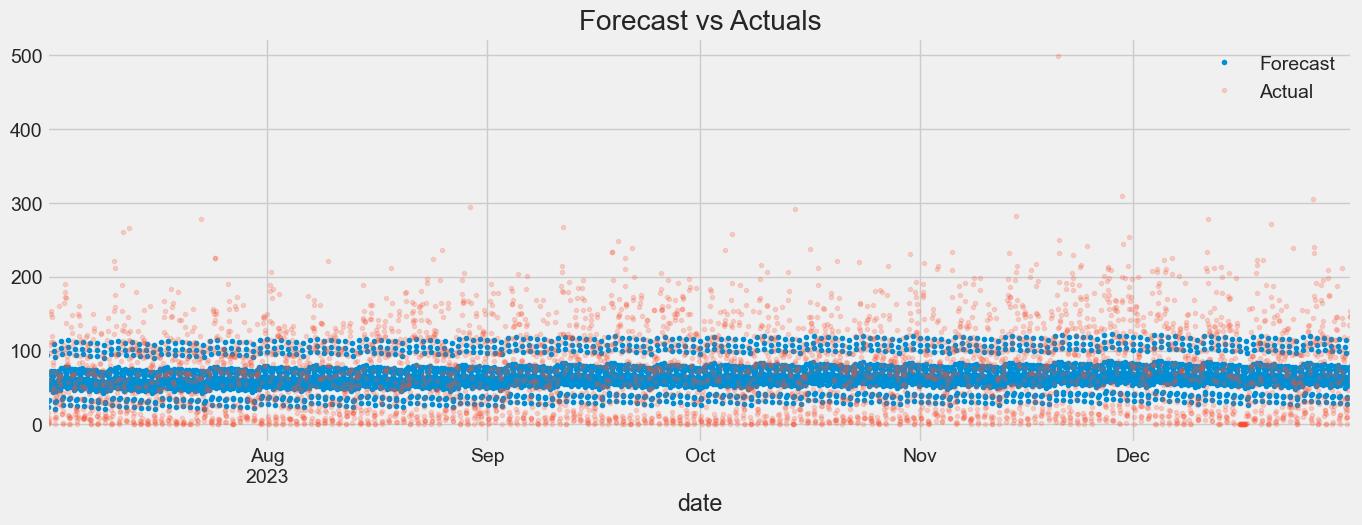

In [ ]:
ax = df_hourly_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
df_hourly_test['calls'].plot(ax=ax,
                          style='.',
                          lw=0,
                          alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()